# Data Preprocessing

In [1]:
import pandas as pd
df = pd.read_csv("SpotifyFeatures.csv")
print (df.shape)
print (df.columns)
df.isnull().sum(axis=0)
# no null values

def search(df,i):
    if df[df['artist_name'].str.contains(i)].shape[0]>0:
         return df[df['artist_name'].str.contains(i)]
    return df[df['track_name'].str.contains(i)]

cols = ['artist_name', 'track_name','track_id','acousticness', 'danceability', 'duration_ms', 'energy','instrumentalness', 'key', 'liveness', 'loudness', 'mode','speechiness', 'tempo', 'time_signature', 'valence']



(232725, 18)
Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')


genre 26 ['Movie' 'R&B' 'A Capella' 'Alternative' 'Country' 'Dance' 'Electronic'
 'Anime' 'Folk' 'Blues' 'Opera' 'Hip-Hop' "Children's Music" 'Rap' 'Indie'
 'Classical' 'Pop' 'Reggae' 'Reggaeton' 'Jazz' 'Rock' 'Ska' 'Comedy'
 'Soul' 'Soundtrack' 'World']
artist_name 14564 !!! 정진우
track_name 148627 " La Traviata " : Amami Alfredo (Act II) - Digitally Remastered 희재
track_id 176774 00021Wy6AyMbLP2tqij86e 7zzbfi8fvHe6hm342GcNYl
popularity 101 0 100
acousticness 4734 0.0 0.996
danceability 1295 0.0569 0.989
duration_ms 70749 15387 5552917
energy 2517 2.03e-05 0.999
instrumentalness 5400 0.0 0.999
key 12 ['C#' 'F#' 'C' 'F' 'G' 'E' 'D#' 'G#' 'D' 'A#' 'A' 'B']
liveness 1732 0.00967 1.0
loudness 27923 -52.457 3.744
mode 2 ['Major' 'Minor']
speechiness 1641 0.0222 0.967
tempo 78512 30.379 242.903
time_signature 5 ['4-Apr' '4-May' '4-Mar' '4-Jan' '0/4']
valence 1692 0.0 1.0


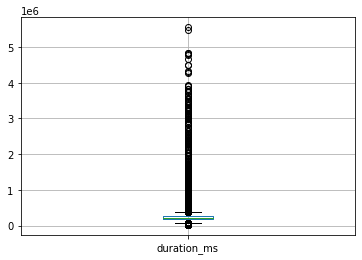

In [2]:
for i in df.columns:
    if (df[i].nunique()>30):
        print (i,df[i].nunique(),min(df[i].unique()),max(df[i].unique()))
    else:
        print (i,df[i].nunique(),df[i].unique())

# duration has unusually huge range
boxplot = df.boxplot(column=['duration_ms'])
df['artist_name'] = df['artist_name'].str.lower()
df['track_name'] = df['track_name'].str.lower()
df['genre'] = df['genre'].str.lower()
df['artist_name'] = df['artist_name'].str.strip()
df['track_name'] = df['track_name'].str.strip()
df['genre'] = df['genre'].str.strip()
df['genre'] = df['genre'].str.replace("’","'")
# only a few rows have duration more than 2e6
# upon careful inspection it seems that the rows above 2e6 (33 mins) are either podcasts or mixtapes, 
# hence we remove those rows from dataset
df_filtered = df[df['duration_ms']<2e6]
df_filtered.reset_index(inplace=True,drop=True)

# there are multiple rows with same song but different popularity, so we grouped by on cols and kept the max popularity
idx = df_filtered.groupby('track_id')['popularity'].transform(max) == df_filtered['popularity']
df_filtered = df_filtered[idx]
df_filtered.reset_index(inplace=True,drop=True)
cols.remove('track_name')
cols.append('popularity')
idx = df_filtered.groupby(cols)['track_name'].transform(max) == df_filtered['track_name']
df_filtered = df_filtered[idx]
df_filtered.reset_index(inplace=True,drop=True)

# another weird thing is that among 232725 rows there are just 148615 unique track names
# this is because songs are present across multiple genres in separate rows
# we are grouping by on same songs and one hot encoding the genre
cols = df_filtered.columns.tolist()
cols.remove('genre')
df_filtered['num_gen'] = df_filtered.groupby(cols,as_index=False)['genre'].transform(len)

df_filtered.reset_index(inplace=True,drop=True)
dummy_genre = pd.get_dummies(df_filtered['genre'], prefix='genre')
df_filtered = pd.merge(left=df_filtered,
        right=dummy_genre,
        left_index=True,
        right_index=True,
    )

df_filtered = df_filtered.drop(columns='genre')
cols = []
cols_genre = []
for i in df_filtered.columns:
    if 'genre' not in i:
        cols.append(i)
    else:
        cols_genre.append(i)

df_filtered = df_filtered.groupby(cols, as_index=False)[cols_genre].apply(lambda x : x.astype(int).sum())
df_filtered.reset_index(inplace=True,drop=True)


dummy_genre = pd.get_dummies(df_filtered['key'], prefix='key')
df_filtered = pd.merge(left=df_filtered,
        right=dummy_genre,
        left_index=True,
        right_index=True,
    )
df_filtered = df_filtered.drop(columns='key')

dummy_genre = pd.get_dummies(df_filtered['mode'], prefix='mode')
df_filtered = pd.merge(left=df_filtered,
        right=dummy_genre,
        left_index=True,
        right_index=True,
    )
df_filtered = df_filtered.drop(columns='mode')


dummy_genre = pd.get_dummies(df_filtered['time_signature'], prefix='time_signature')
df_filtered = pd.merge(left=df_filtered,
        right=dummy_genre,
        left_index=True,
        right_index=True,
    )
df_filtered = df_filtered.drop(columns='time_signature')

In [3]:
df_filtered.to_csv('Spotify_dataset_filtered.csv',index=False)

In [4]:
print (df_filtered.shape)
print (df_filtered.track_id.nunique())

(176673, 60)
176671


# Reading filtered dataset

In [5]:
df = pd.read_csv("Spotify_dataset_filtered.csv")
df.shape

(176673, 60)

## EDA and Data visualization

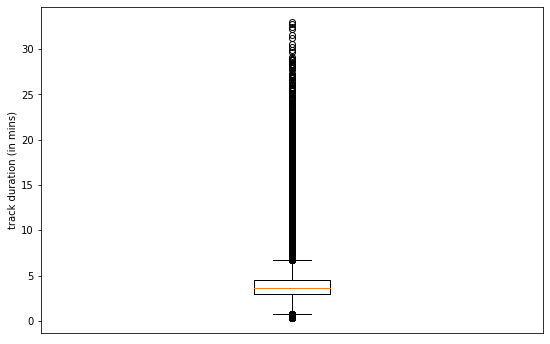

In [6]:
# boxplot of duration (mins)
import matplotlib.pyplot as plt
import seaborn as sns

duration_mins = df["duration_ms"] / 60000

plt.figure(1, figsize=(9,6))
plt.boxplot(duration_mins)
plt.xlabel("")
plt.ylabel("track duration (in mins)")
plt.xticks([])
plt.show()

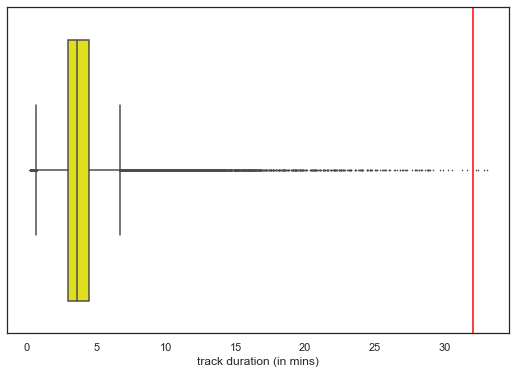

In [8]:
# Beautified the above plot
plt.figure(2, figsize=(9,6))
sns.set_theme(style = "white", palette="pastel")
ax = sns.boxplot(x = duration_mins, color = "yellow", fliersize=0.75)
plt.xlabel("track duration (in mins)")
plt.ylabel("")
plt.yticks([])
plt.axvline(x = 2**5, color = "red")
plt.show()

In [9]:
# Identift top five genres by popularity 
df_old = pd.read_csv("SpotifyFeatures.csv")
mean_popularity_by_genre = df_old.groupby("genre")["popularity"].mean().sort_values(ascending = False)
top_5_most_popular_genres = mean_popularity_by_genre.index[:5]
top_5_most_popular_genres

Index(['Pop', 'Rap', 'Rock', 'Hip-Hop', 'Dance'], dtype='object', name='genre')

In [137]:
# A peek at some of the most popular songs
top_5_most_popular = df_old[df_old["genre"].isin(top_5_most_popular_genres)]
top_5_most_popular.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
9026,Dance,Ariana Grande,"break up with your girlfriend, i'm bored",4kV4N9D1iKVxx1KLvtTpjS,99,0.0421,0.726,190440,0.554,0.000000,F,0.1060,-5.290,Minor,0.0917,169.999,4-Apr,0.335
9027,Dance,Ariana Grande,7 rings,14msK75pk3pA33pzPVNtBF,100,0.5780,0.725,178640,0.321,0.000000,C#,0.0884,-10.744,Minor,0.3230,70.142,4-Apr,0.319
9028,Dance,Halsey,Without Me,5p7ujcrUXASCNwRaWNHR1C,97,0.2970,0.752,201661,0.488,0.000009,F#,0.0936,-7.050,Major,0.0705,136.041,4-Apr,0.533
9029,Dance,Ariana Grande,needy,1TEL6MlSSVLSdhOSddidlJ,92,0.7800,0.647,171573,0.309,0.000007,G,0.2020,-7.948,Minor,0.0366,87.045,4-Apr,0.195
9030,Dance,Ariana Grande,NASA,4uTvPEr01pjTbZgl7jcKBD,91,0.4510,0.747,182000,0.458,0.000000,F#,0.2520,-6.891,Major,0.3030,75.029,4-Apr,0.470


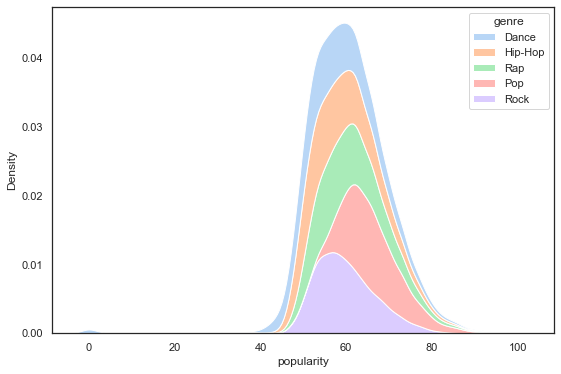

In [138]:
# KDE plot for top five most-popular genres
plt.figure(3, figsize=(9,6))
genres = top_5_most_popular['genre']
sns.kdeplot(top_5_most_popular['popularity'], shade = True, hue = genres, multiple='stack');
#plt.legend(loc = "center right", bbox_to_anchor=(1,1));

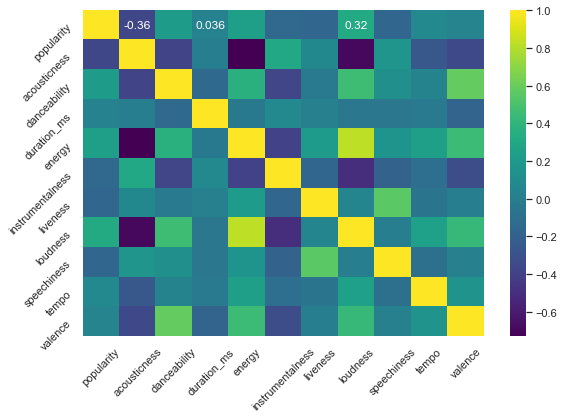

In [215]:
# Correlation plot of numerical features
import numpy as np
plt.figure(4, figsize = (9,6))
df_numerical_cols = df[['popularity', 'acousticness',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness',
       'loudness', 'speechiness', 'tempo', 'valence']]
corr_matrix = df_numerical_cols.corr()
labels = np.array([["","-0.36","","0.036","","","","0.32","","",""],\
          ["","","","","","","","","","",""],["","","","","","","","","","",""],\
          ["","","","","","","","","","",""],["","","","","","","","","","",""],\
          ["","","","","","","","","","",""],["","","","","","","","","","",""],\
          ["","","","","","","","","","",""],["","","","","","","","","","",""],\
          ["","","","","","","","","","",""],["","","","","","","","","","",""]])
#labels = np.empty((11,11), dtype = "S3")
sns.heatmap(corr_matrix, annot = labels, cmap = "viridis", fmt="")
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()
#plt.title("Correlation between features", fontsize = 15);

In [141]:
top_5_artists_data = top_5_most_popular[top_5_most_popular["artist_name"].isin(top_5_artists)]
top_5_artists_data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
9026,Dance,Ariana Grande,"break up with your girlfriend, i'm bored",4kV4N9D1iKVxx1KLvtTpjS,99,0.0421,0.726,190440,0.554,0.000000,F,0.1060,-5.290,Minor,0.0917,169.999,4-Apr,0.335
9027,Dance,Ariana Grande,7 rings,14msK75pk3pA33pzPVNtBF,100,0.5780,0.725,178640,0.321,0.000000,C#,0.0884,-10.744,Minor,0.3230,70.142,4-Apr,0.319
9028,Dance,Halsey,Without Me,5p7ujcrUXASCNwRaWNHR1C,97,0.2970,0.752,201661,0.488,0.000009,F#,0.0936,-7.050,Major,0.0705,136.041,4-Apr,0.533
9029,Dance,Ariana Grande,needy,1TEL6MlSSVLSdhOSddidlJ,92,0.7800,0.647,171573,0.309,0.000007,G,0.2020,-7.948,Minor,0.0366,87.045,4-Apr,0.195
9030,Dance,Ariana Grande,NASA,4uTvPEr01pjTbZgl7jcKBD,91,0.4510,0.747,182000,0.458,0.000000,F#,0.2520,-6.891,Major,0.3030,75.029,4-Apr,0.470


In [142]:
top_5_artists_data["artist_name"].unique()

array(['Ariana Grande', 'Halsey', 'Daddy Yankee', 'Post Malone',
       'Sam Smith'], dtype=object)

Text(0.5, 0, '')

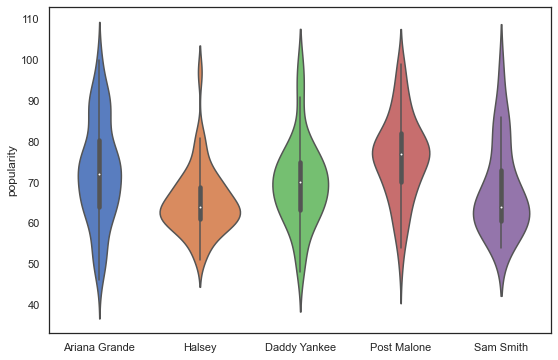

In [143]:
# Violin plot of popularity of top 5 most-popular artists
plt.figure(5, figsize = (9,6))
sns.violinplot(x = "artist_name", y="popularity", data=top_5_artists_data, palette="muted")
plt.xlabel("")

In [160]:
df_plots = df.select_dtypes(exclude = "int64")
df_plots = pd.concat([df_plots, df["popularity"]], axis = 1)
df_plots.drop(['artist_name', 'track_name', 'track_id'], axis = 1, inplace = True)
df_plots.head()

def isasongacoustic(x):
    if x >= 0.5:
        return "Acoustic"
    else:
        return "Not acoustic"

df_plots["acoustic"] = df_plots["acousticness"].apply(lambda x:isasongacoustic(x))
df_plots.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,acoustic
0,0.00412,0.874,0.814,0.464000,0.0690,-6.873,0.0450,121.976,0.741,40,Not acoustic
1,0.00310,0.630,0.927,0.739000,0.1820,-6.540,0.0457,120.654,0.611,36,Not acoustic
2,0.02490,0.865,0.650,0.000391,0.1020,-8.025,0.1010,120.030,0.557,36,Not acoustic
3,0.00339,0.857,0.762,0.310000,0.0643,-6.327,0.0535,120.010,0.804,45,Not acoustic
4,0.02380,0.803,0.876,0.617000,0.0432,-8.186,0.0385,114.983,0.881,33,Not acoustic


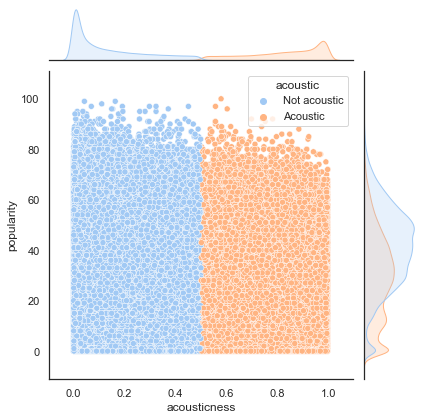

In [163]:
sns.jointplot(x = "acousticness", y="popularity", data = df_plots, hue = "acoustic")

In [168]:
df_popular_more_than_50 = df_plots[df_plots["popularity"] > 50]
df_popular_le_than_50 = df_plots[df_plots["popularity"] <= 50]
df_popular_le_than_50.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,acoustic
0,0.00412,0.874,0.814,0.464000,0.0690,-6.873,0.0450,121.976,0.741,40,Not acoustic
1,0.00310,0.630,0.927,0.739000,0.1820,-6.540,0.0457,120.654,0.611,36,Not acoustic
2,0.02490,0.865,0.650,0.000391,0.1020,-8.025,0.1010,120.030,0.557,36,Not acoustic
3,0.00339,0.857,0.762,0.310000,0.0643,-6.327,0.0535,120.010,0.804,45,Not acoustic
4,0.02380,0.803,0.876,0.617000,0.0432,-8.186,0.0385,114.983,0.881,33,Not acoustic


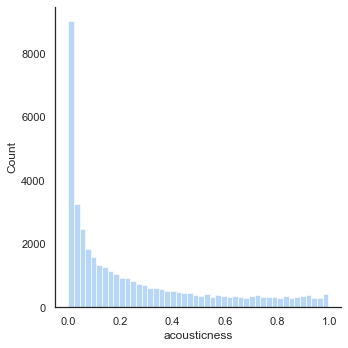

In [167]:
sns.displot(df_popular_more_than_50["acousticness"])

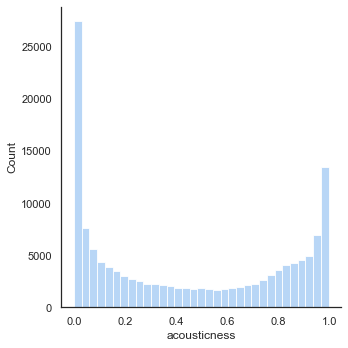

In [169]:
sns.displot(df_popular_le_than_50["acousticness"])

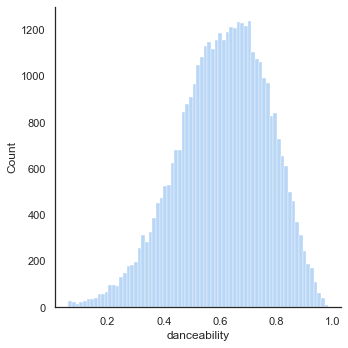

In [170]:
sns.displot(df_popular_more_than_50["danceability"])

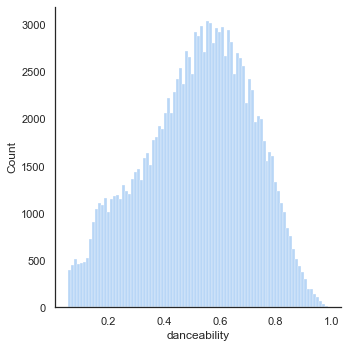

In [171]:
sns.displot(df_popular_le_than_50["danceability"])

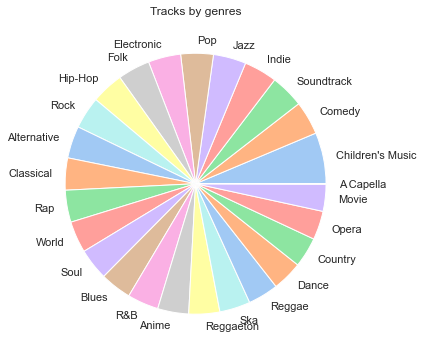

In [172]:
# Pie chart of song counts per genre

fig = plt.figure(11, figsize = (9, 6))
ax = fig.subplots()
df_old.genre.value_counts().plot(ax=ax, kind = "pie")
ax.set_ylabel("")
ax.set_title("Tracks by genres")
plt.show()

In [173]:
df.head()

,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,...,key_F#,key_G,key_G#,mode_Major,mode_Minor,time_signature_0/4,time_signature_4-Apr,time_signature_4-Jan,time_signature_4-Mar,time_signature_4-May
0,!!!,all u writers,2pPhbWZBm3Q6b35jV691qG,40,0.00412,0.874,322623,0.814,0.464000,0.0690,...,0,0,0,0,1,0,1,0,0,0
1,!!!,bend over beethoven,5PRM1a5qRJpsFzkz8VyRUY,36,0.00310,0.630,486813,0.927,0.739000,0.1820,...,0,0,0,1,0,0,1,0,0,0
2,!!!,californiyeah,5OAv07sMKALt6qWV3q90J8,36,0.02490,0.865,274013,0.650,0.000391,0.1020,...,0,0,0,0,1,0,1,0,0,0
3,!!!,dancing is the best revenge,2PAn8J9dbmSnR4fLjpgehC,45,0.00339,0.857,281558,0.762,0.310000,0.0643,...,0,0,0,1,0,0,1,0,0,0
4,!!!,dear can,3LgIR6H0HUXu0HiTLSF1zj,33,0.02380,0.803,277133,0.876,0.617000,0.0432,...,1,0,0,1,0,0,1,0,0,0


In [176]:
df_old["genre"].unique()

array(['Movie', 'R&B', 'A Capella', 'Alternative', 'Country', 'Dance',
       'Electronic', 'Anime', 'Folk', 'Blues', 'Opera', 'Hip-Hop',
       "Children's Music", 'Rap', 'Indie', 'Classical', 'Pop', 'Reggae',
       'Reggaeton', 'Jazz', 'Rock', 'Ska', 'Comedy', 'Soul', 'Soundtrack',
       'World'], dtype=object)

In [178]:
# What are children listening to? Pop or Rock or Hip-Hop
from matplotlib_venn import venn2

In [179]:
gens = ["Pop", "Hip-Hop", "Rock", "Children's Music"]
df_gens = df_old[df_old["genre"].isin(gens)]
df_gens.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
66607,Hip-Hop,J. Cole,MIDDLE CHILD,2JvzF1RMd7lE3KmFlsyZD8,96,0.14900,0.837,213594,0.364,0.00000,G#,0.2710,-11.713,Major,0.2760,123.984,4-Apr,0.463
66608,Hip-Hop,Meek Mill,Going Bad (feat. Drake),2IRZnDFmlqMuOrYOLnZZyc,95,0.25900,0.889,180522,0.496,0.00000,E,0.2520,-6.365,Minor,0.0905,86.003,4-Apr,0.544
66609,Hip-Hop,21 Savage,a lot,2t8yVaLvJ0RenpXUIAC52d,93,0.03950,0.837,288624,0.636,0.00125,C#,0.3420,-7.643,Major,0.0860,145.972,4-Apr,0.274
66610,Hip-Hop,Rich The Kid,Splashin,79OEIr4J4FHV0O3KrhaXRb,88,0.00195,0.942,177806,0.383,0.00000,A#,0.0922,-8.099,Major,0.5650,100.021,4-Apr,0.380
66611,Hip-Hop,Sheck Wes,Mo Bamba,1xzBco0xcoJEDXktl7Jxrr,92,0.19400,0.729,183907,0.625,0.00986,E,0.2480,-5.266,Major,0.0315,146.034,4-Apr,0.261


In [180]:
set_children = set(df_gens[df_gens["genre"] == "Children's Music"]["track_id"].unique())
set_rock = set(df_gens[df_gens["genre"] == "Rock"]["track_id"].unique())
set_pop = set(df_gens[df_gens["genre"] == "Pop"]["track_id"].unique())
set_hip_hop = set(df_gens[df_gens["genre"] == "Hip-Hop"]["track_id"].unique())

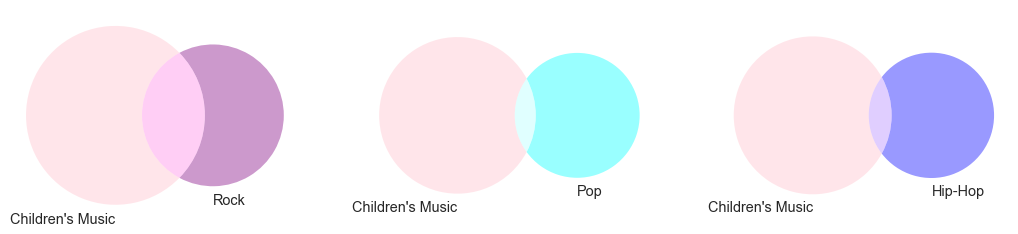

In [203]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18,9))

out1 = venn2([set_children, set_rock], ("Children's Music", "Rock"), set_colors=("pink", "purple"), ax = ax1)
out2 = venn2([set_children, set_pop], ("Children's Music", "Pop"), set_colors=("pink", "cyan"), ax = ax2)
out3 = venn2([set_children, set_hip_hop], ("Children's Music", "Hip-Hop"), set_colors=("pink", "blue"), ax = ax3)

for out in [out1, out2, out3]:
    for idx, subset in enumerate(out.subset_labels):
        out.subset_labels[idx].set_visible(False)

plt.show()

# What are children listening to? Pop or Rock or Hip-Hop

In [216]:
df.shape

(176673, 60)

In [217]:
df_pairplot = df[["popularity", "duration_ms", "loudness", "acousticness"]]
df_pairplot.head()

,popularity,duration_ms,loudness,acousticness
0,40,322623,-6.873,0.00412
1,36,486813,-6.540,0.00310
2,36,274013,-8.025,0.02490
3,45,281558,-6.327,0.00339
4,33,277133,-8.186,0.02380


In [223]:
# sns.pairplot(df_pairplot, corner=True, kind = "kde")
df_pairplot.popularity.unique()

array([ 40,  36,  45,  33,  35,  61,  37,  44,  39,  43,  48,  41,  42,
        53,  34,  38,  23,  27,  21,  30,  24,  20,  29,  31,  22,  16,
        28,  26,  19,  49,  25,  50,  56,  67,  59,  58,  55,  52,  64,
        70,  54,  74,  60,  51,  63,  62,  72,  66,  65,  78,  68,  69,
        76,  57,  73,  75,  47,  46,  71,  32,  13,  77,  80,  93,  84,
        85,  14,  18,  15,  79,  12,  87,  88,  86,  81,  82,  17,  83,
        91,   0,  11,   9,   7,  10,   8,   6,   4,   5,   3,   2,   1,
        92,  96, 100,  99,  90,  95,  97,  89,  94,  98])

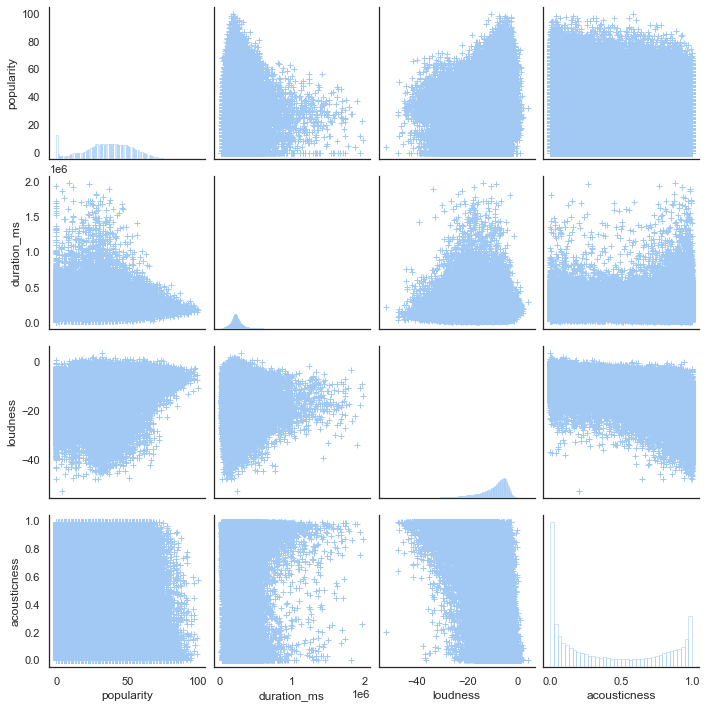

In [221]:
sns.pairplot(
    df_pairplot,
    plot_kws=dict(marker="+", linewidth=1),
    diag_kws=dict(fill=False),
)

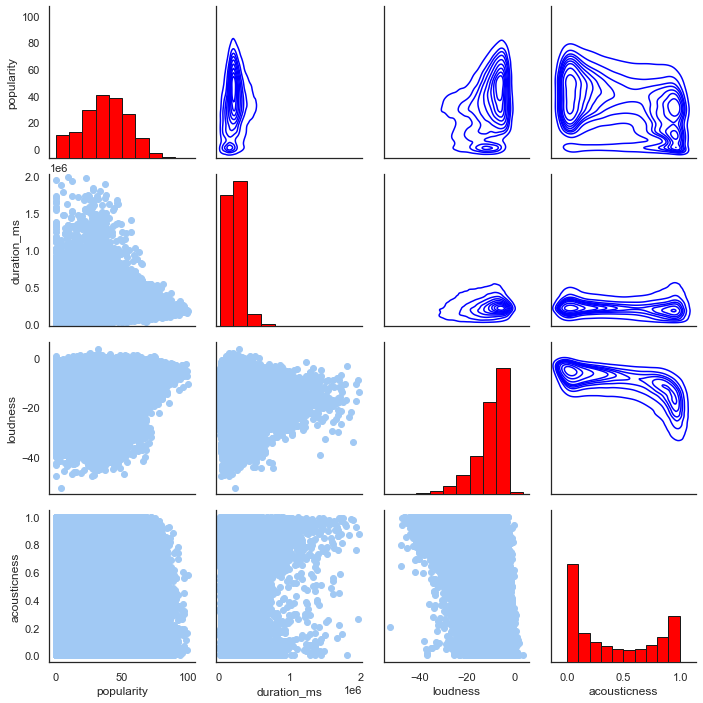

In [239]:
grid = sns.PairGrid(df_pairplot)

# Map a scatter plot to the upper triangle
grid = grid.map_upper(sns.kdeplot, color = 'blue')

# Map a histogram to the diagonal
grid = grid.map_diag(plt.hist, bins = 10, color = 'red', 
                     edgecolor = 'k')
# Map a density plot to the lower triangle
grid = grid.map_lower(plt.scatter, cmap = 'green')

In [225]:
top_5_most_popular.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
9026,Dance,Ariana Grande,"break up with your girlfriend, i'm bored",4kV4N9D1iKVxx1KLvtTpjS,99,0.0421,0.726,190440,0.554,0.000000,F,0.1060,-5.290,Minor,0.0917,169.999,4-Apr,0.335
9027,Dance,Ariana Grande,7 rings,14msK75pk3pA33pzPVNtBF,100,0.5780,0.725,178640,0.321,0.000000,C#,0.0884,-10.744,Minor,0.3230,70.142,4-Apr,0.319
9028,Dance,Halsey,Without Me,5p7ujcrUXASCNwRaWNHR1C,97,0.2970,0.752,201661,0.488,0.000009,F#,0.0936,-7.050,Major,0.0705,136.041,4-Apr,0.533
9029,Dance,Ariana Grande,needy,1TEL6MlSSVLSdhOSddidlJ,92,0.7800,0.647,171573,0.309,0.000007,G,0.2020,-7.948,Minor,0.0366,87.045,4-Apr,0.195
9030,Dance,Ariana Grande,NASA,4uTvPEr01pjTbZgl7jcKBD,91,0.4510,0.747,182000,0.458,0.000000,F#,0.2520,-6.891,Major,0.3030,75.029,4-Apr,0.470


<AxesSubplot:xlabel='popularity', ylabel='genre'>

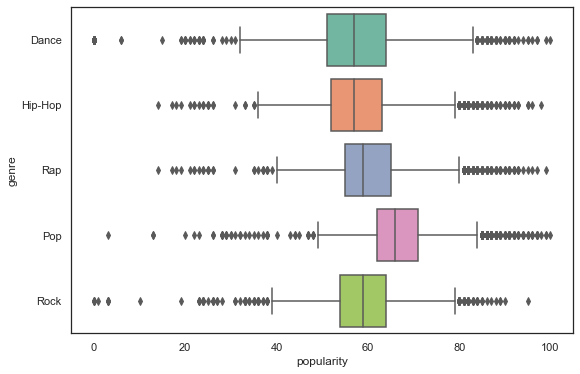

In [238]:
plt.figure(21, figsize=(9,6))
sns.boxplot(x = "popularity", y = "genre", data = top_5_most_popular, dodge = False, orient = "h", palette="Set2")

In [240]:
df_pairplot.head()

,popularity,duration_ms,loudness,acousticness
0,40,322623,-6.873,0.00412
1,36,486813,-6.540,0.00310
2,36,274013,-8.025,0.02490
3,45,281558,-6.327,0.00339
4,33,277133,-8.186,0.02380


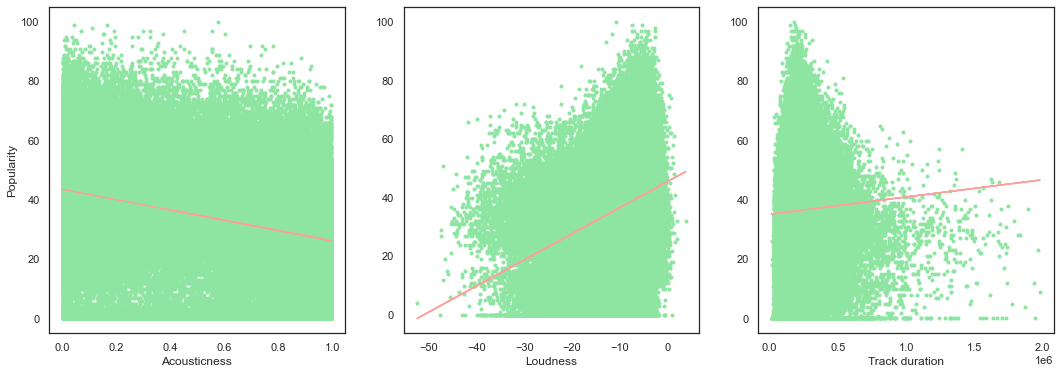

In [258]:

fig2, (ax11, ax12, ax13) = plt.subplots(1,3, figsize = (18,6))
from numpy.polynomial.polynomial import polyfit
x, y = df_pairplot["acousticness"], df_pairplot["popularity"]
b, m = polyfit(x, y, 1)

plt.subplot(1,3,1)
plt.plot(x, y, '.', color = "g")
plt.plot(x, b + m * x, '-', color = "r")
plt.xlabel("Acousticness")
plt.ylabel("Popularity")


x, y = df_pairplot["loudness"], df_pairplot["popularity"]
b, m = polyfit(x, y, 1)

plt.subplot(1,3,2)
plt.plot(x, y, '.', color = "g")
plt.plot(x, b + m * x, '-', color = "r")
plt.xlabel("Loudness")
plt.ylabel("")


x, y = df_pairplot["duration_ms"], df_pairplot["popularity"]
b, m = polyfit(x, y, 1)

plt.subplot(1,3,3)
plt.plot(x, y, '.', color = "g")
plt.plot(x, b + m * x, '-', color = "r")
plt.xlabel("Track duration")
plt.ylabel("")

plt.show()
#plt.scatter(df_pairplot["acousticness"], df_pairplot["popularity"], marker = "^", alpha = 0.5)

In [259]:
df.shape

(176673, 60)

<AxesSubplot:xlabel='popularity', ylabel='Density'>

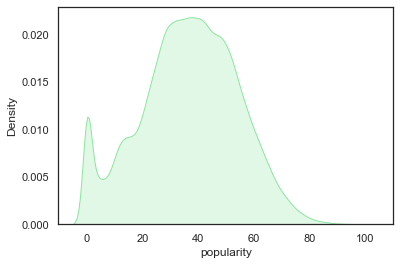

In [266]:
sns.kdeplot(df["popularity"], shade=True, color="g")